In [33]:
import numpy as np
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple
from multiprocessing import Pool
from itertools import repeat
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 18})

from definitions import ROOT_DIR
from unc.utils import load_info

In [34]:
# COLORS

emerald = "#2ecc71"
turquoise = "#1abc9c"
peter_river = "#3498db"
sunflower = "#f1c40f"
alizarin = "#e74c3c"
pumpkin = "#d35400"
green_sea = "#16a085"
wisteria = "#8e44ad"
midnight_blue = "#2c3e50"


In [108]:
level = 8
# all_paths = {
# #     f'uf{level}a_cnn': Path(ROOT_DIR, 'results', f'uf{level}a_cnn'),
#     f'uf{level}m_cnn':  Path(ROOT_DIR, 'results', 'uf8_sweep_4m', f'uf{level}m_cnn'),
#     f'uf{level}m_cnn_lstm':  Path(ROOT_DIR, 'results', 'uf8_sweep_4m', f'uf{level}m_cnn_lstm'),
# }
all_paths = {
    f'uf{level}a_cnn': Path(ROOT_DIR, 'results', f'uf{level}a_cnn'),
    f'uf{level}m_cnn':  Path(ROOT_DIR, 'results', f'uf{level}m_cnn'),
    f'uf{level}m_cnn_lstm':  Path(ROOT_DIR, 'results', f'uf{level}m_cnn_lstm'),
}

plot_info = {
    f'uf{level}a_cnn': {'color': midnight_blue, 'label': 'Ground-truth'},
    f'uf{level}m_cnn_lstm': {'color': sunflower, 'label': 'LSTM'},
    f'uf{level}m_cnn_lstm_unc': {'color': wisteria, 'label': 'LSTM + Aux inputs'},
    f'uf{level}m_cnn': {'color': green_sea, 'label': 'Normal'},
    f'uf{level}m_cnn_unc': {'color': pumpkin, 'label': 'Aux inputs'}
}

plot_order = [
    f'uf{level}a_cnn',
    f'uf{level}m_cnn',
    f'uf{level}m_cnn_lstm',
    f'uf{level}m_cnn_unc',
    f'uf{level}m_cnn_lstm_unc'
]
split_by = ['buffer_size', 'step_size', 'arch', 'uncertainty_decay', 'slip_prob', 'trunc', 'total_steps']
Args = namedtuple('args', split_by)


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [81]:
def process_dir(dir_path, split_by, w=10):
    all_results = {}

        
    for f in tqdm(list(dir_path.iterdir())):
        if f.suffix != ".npy":
            continue
        info = load_info(f)
        args = info['args'].item()
        if "arch" not in args:
            args['arch'] = 'nn'
            
        if args['trunc'] > 10:
            continue
            
#         if args["arch"] == "cnn_lstm" and args["uncertainty_decay"] < 1.:
#             continue
#         if args["total_steps"] < 4e6:
#             continue
            
        
        reward = info['reward']
        offline_key = 'offline_eval_reward'
        if 'offline_eval_returns' in info:
            offline_key = 'offline_eval_returns'
        offline_returns = info[offline_key]

        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

        all_results[hparams].append((reward, offline_returns, args, f))


    
    return all_results

    

In [94]:
def group_by(dataset, key, label_head, groups=None, add_labels=None):
    grouped_data = {}
    for args, d in dataset.items():
        key_val = getattr(args, key)

        if groups is not None:
            assert add_labels is not None and len(add_labels) == len(groups)
            full_label = label_head
            grouped = False
            none_idx = None
            
            for i, g in enumerate(groups):
                add_label = False
                
                if g is not None and key_val in g:
                    if add_labels[i] is not None:
                        full_label += f'_{add_labels[none_idx]}' 
                    grouped = True
                    break
                elif g is None:
                    none_idx = i
                    
            if not grouped:
                if none_idx is None:
                    print(f"skipping {key_val}")
                else:
                    if add_labels[i] is not None:
                        full_label += f'_{add_labels[none_idx]}'
        else:     
            full_label = label_head + f'_{key}_{key_val}'
            
        if full_label not in grouped_data:
            grouped_data[full_label] = {}
        
        grouped_data[full_label][args] = d
    return grouped_data


In [83]:
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by)
    raw_data[key] = processed

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

In [84]:
arg_example = list(raw_data[f'uf{level}m_cnn'].values())[0][0][2]
steps_per_eval = arg_example['offline_eval_freq']

In [98]:
key = 'uncertainty_decay'
split_files = [f'uf{level}m_cnn', f'uf{level}m_cnn_lstm']
unc_decay_groups = [[1.], None]
additional_labels = [None, 'unc']

new_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_data[split_file], key, split_file, groups=unc_decay_groups, add_labels=additional_labels)
    for k, v in new_grouped.items():
        new_raw[k] = v
        
for k, v in raw_data.items():
    if k not in split_files:
        new_raw[k] = v

In [99]:
no_slip_raw = {}
slip_raw = {}

for k, v in new_raw.items():
    new_v_slip = {}
    new_v_no_slip = {}
    
    for k_arg, v_arg in v.items():
        if k_arg.slip_prob > 0.:
            new_v_slip[k_arg] = v_arg
        else:
            new_v_no_slip[k_arg] = v_arg
    slip_raw[k] = new_v_slip
    no_slip_raw[k] = new_v_no_slip

In [100]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data.items():
        final_max = np.mean([np.mean(offline_rew[-eps_max_over:]) for online_rew, offline_rew, all_args, fname in all_dis_rew])
#         final_max = np.mean([np.mean(offline_rew) for online_rew, offline_rew, all_args, fname in all_dis_rew])

        fnames = [fname for _, _, _, fname in all_dis_rew]
        hparam_results.append((args, final_max, fnames))
    return hparam_results



In [103]:
max_overs_slip = {}

for g, v in slip_raw.items():
    max_overs_slip[g] = get_eps_max_over(v, eps_max_over=100)
    

In [104]:
# Get the best hyperparams based on the final 100 episodes
all_best_slip = {}
for key, v in max_overs_slip.items():
    all_best_slip[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

all_best_slip

{'uf8m_cnn_unc': (args(buffer_size=100000, step_size=1e-06, arch='cnn', uncertainty_decay=0.85, slip_prob=0.1, trunc=10, total_steps=6000000),
  28.037679999999995,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn/d07cfab3e130f0befc62388307d35b33_Mon May 30 22:40:11 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn/81556b855c32a0ba34c68c996baa5b57_Tue May 24 13:28:39 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn/e387e0bc11a363629741d0eb2da0edfb_Tue May 31 08:38:42 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn/4f8e102c58dad404c10d0f3b8519c97f_Tue May 24 13:28:39 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn/852d6e55a525b9b3309397b2957ab68b_Tue May 31 08:38:42 2022.npy')]),
 'uf8m_cnn': (args(buffer_size=100000, step_size=1e-06, arch='cnn', uncertainty_decay=1.0, slip_prob=0.1, trunc=10, total_steps=6000000),
  19.1988,
  [PosixPath('

In [105]:
# trunc = int(1e6)
all_mapped_data_slip = {}
for key, v in all_best_slip.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in slip_raw[key][arg]]
    all_mapped_data_slip[key] = np.stack(all_seeds)
    


In [106]:
all_mapped_data_slip

{'uf8m_cnn_unc': array([[11.9 , 15.54, 15.52, ..., 28.02, 24.18, 25.82],
        [11.16, 14.66, 15.52, ..., 28.08, 25.76, 29.68],
        [19.84, 20.14, 17.8 , ..., 31.48, 26.68, 30.14],
        [ 1.84, 17.3 , 19.34, ..., 32.34, 31.44, 29.44],
        [12.96, 13.74, 15.94, ..., 28.4 , 30.4 , 27.56]]),
 'uf8m_cnn': array([[ 4.26,  6.08, 11.82, ..., 18.28, 16.02, 18.32],
        [ 5.44,  8.78, 11.94, ..., 18.82, 18.44, 17.02],
        [12.02, 14.28, 17.38, ..., 19.58, 19.58, 16.98],
        [ 8.52,  6.8 ,  3.92, ..., 19.8 , 19.  , 18.8 ],
        [11.3 , 15.6 , 12.9 , ..., 18.52, 20.74, 19.58]]),
 'uf8m_cnn_lstm_unc': array([[21.38, 18.34, 18.68, ..., 27.02, 29.58, 28.2 ],
        [17.24, 19.96, 18.96, ..., 32.36, 27.68, 33.74],
        [ 0.26,  6.74, 20.08, ..., 30.14, 26.4 , 29.56],
        [13.48, 19.12, 20.2 , ..., 27.04, 30.42, 30.44],
        [ 2.08,  4.06,  6.12, ..., 27.54, 30.28, 29.12]]),
 'uf8m_cnn_lstm': array([[15.78, 14.78,  4.66, ..., 24.82, 25.52, 27.3 ],
        [ 2.88, 

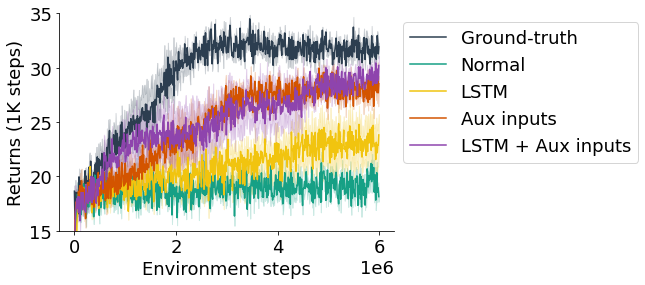

In [109]:
# with slip
fig, ax = plt.figure(), plt.axes()

fig_path = Path(ROOT_DIR, 'results', 'uf8_results.pdf')

for k in plot_order:
    data = all_mapped_data_slip[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_ylim(15, 35)
# ax.set_ylim(15, 30)

# ax.set_yticks([18, 22, 26])
ax.set_xlabel('Environment steps')
# ax.set_ylabel(f"Returns (1K steps)", rotation=0, labelpad=65)
ax.set_ylabel(f"Returns (1K steps)")
# ax.yaxis.set_label_coords(-0.15, 0.65)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.text(1.5e6, 16.5, "Observations", color=plot_info[f'uf{level}m_cnn_uncertainty_decay_1.0']['color'], fontdict=dict(size=18))
# plt.text(3.03e6, 22.25, "Auxiliary\nInputs", color=plot_info[f'uf{level}m_cnn_uncertainty_decay_0.85']['color'], fontdict=dict(size=18))
# plt.text(3.03e6, 20.75, "LSTM", color=plot_info[f'uf{level}m_cnn_lstm_uncertainty_decay_1.0']['color'], fontdict=dict(size=18))
# plt.text(0, 24.5, "LSTM + Auxiliary", color=plot_info[f'uf{level}m_cnn_lstm_uncertainty_decay_0.95']['color'], fontdict=dict(size=18))

# ax.set_title(f'Fishing Environment')

plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
# fig.savefig(fig_path, bbox_inches='tight')



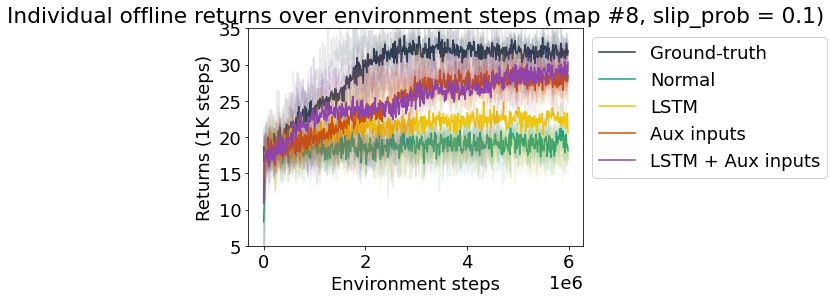

In [60]:
# with slip
fig, ax = plt.figure(), plt.axes()


for k in plot_order:
    data = all_mapped_data_slip[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    ax.plot(x, means, label=key, color=color)

    for d in data:
        ax.plot(x, d, color=color, alpha=0.1)
#     plt.fill_between(x, means - std_err, means + std_err,
#                          color=color, alpha=0.2)

ax.set_ylim(5, 35)
    
ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Returns (1K steps)")
ax.set_title(f'Individual offline returns over environment steps (map #8, slip_prob = 0.1)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [61]:
key = 'trunc'
split_files = [f'uf{level}m_cnn_lstm']
trunc_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_data[split_file], key, split_file)
    for k, v in new_grouped.items():
        trunc_raw[k] = v
        
# for k, v in raw_data.items():
#     if k not in split_files:
#         new_raw[k] = v

In [64]:
max_overs_trunc = {}

for g, v in trunc_raw.items():
    max_overs_trunc[g] = get_eps_max_over(v, eps_max_over=500)


In [65]:
# Get the best hyperparams based on the final 100 episodes
all_best_trunc = {}
for key, v in max_overs_trunc.items():
    filtered_v = [el for el in v if el[0].uncertainty_decay == 1.]
        
    all_best_trunc[key] = sorted(filtered_v, key=lambda x : x[1], reverse=True)[0]

all_best_trunc

{'uf8m_cnn_lstm_trunc_5': (args(buffer_size=100000, step_size=1e-06, arch='cnn_lstm', uncertainty_decay=1.0, slip_prob=0.1, trunc=5, total_steps=6000000),
  21.320944,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/5152d9a92e070ad3ef1607c787603965_Wed May 25 20:24:32 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/5b361733693db3273cc16f64b8d5fc2c_Wed May 25 19:01:15 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/fc53f109ce3fdc76748ff06b8649f085_Wed May 25 20:35:25 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/02733240aaf91e52b9d8fe203a08e220_Wed May 25 20:15:07 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/1e05f49571e3e867e95fe42915ff01d6_Wed May 25 19:38:09 2022.npy')]),
 'uf8m_cnn_lstm_trunc_20': (args(buffer_size=100000, step_size=1e-06, arch='cnn_lstm', uncertainty_decay=1.0, slip_prob=0.1, trunc=20, 

In [66]:
# trunc = int(1e6)
all_mapped_data_trunc = {}

for key, v in all_best_trunc.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in trunc_raw[key][arg]]
    all_mapped_data_trunc[key] = np.stack(all_seeds)
    


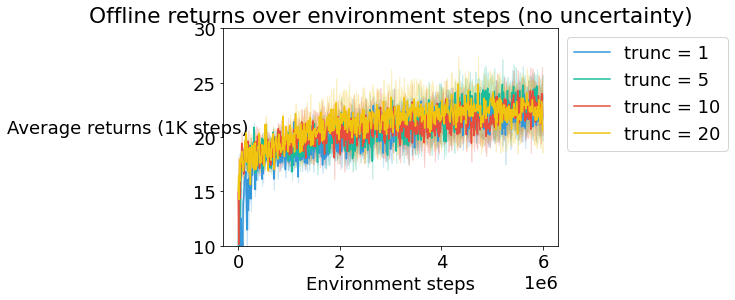

In [76]:
# with trunc

plot_info_trunc = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': 'trunc = 1'},
    f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': 'trunc = 5'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': 'trunc = 10'},
#     f'uf{level}m_cnn_lstm_trunc_15': {'color': turquoise, 'label': 'trunc = 15'},
    f'uf{level}m_cnn_lstm_trunc_20': {'color': sunflower, 'label': 'trunc = 20'}

}

fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)
ax.set_ylim(10, 30)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_44752/614333861.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_44752/614333861.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_44752/614333861.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_44752/61433

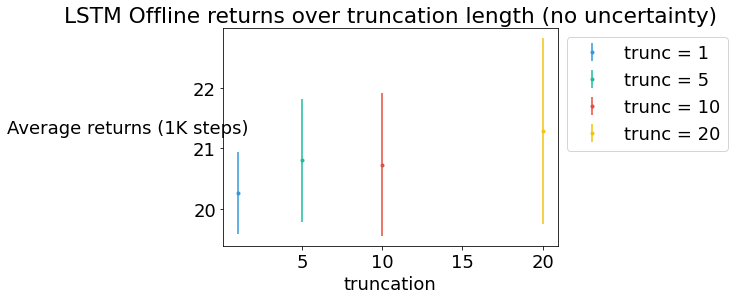

In [77]:
fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.array([int(k.split('_')[-1])])

    step_means = data.mean(axis=-1)
    mean = step_means.mean(axis=0)
    std_err = step_means.std(axis=0) / np.sqrt(step_means.shape[0])

    ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
# ax.set_xlim(0, 11)
# ax.set_ylim(12, 18)

ax.set_xlabel('truncation')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'LSTM Offline returns over truncation length (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [78]:
all_best_trunc_unfiltered = {}
for key, v in max_overs_trunc.items():
        
    all_best_trunc_unfiltered[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

# trunc = int(1e6)
all_mapped_data_trunc_unfiltered = {}

for key, v in all_best_trunc_unfiltered.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in trunc_raw[key][arg]]
    all_mapped_data_trunc_unfiltered[key] = np.stack(all_seeds)
    
all_best_trunc_unfiltered

{'uf8m_cnn_lstm_trunc_5': (args(buffer_size=100000, step_size=1e-06, arch='cnn_lstm', uncertainty_decay=0.95, slip_prob=0.1, trunc=5, total_steps=6000000),
  24.869543999999998,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/3015573fe478295b3c6426b8e23db658_Wed May 25 20:35:25 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/b61b1872a791e731622f377fb3ead66f_Wed May 25 20:46:11 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/ce4ddc4b61fa5484530f48002e6d496c_Wed May 25 20:46:11 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/e7d2d3220c56e1e926bdb3269e749c75_Wed May 25 20:46:11 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/f20bf0162b87d985f48fafd384c284da_Wed May 25 20:46:11 2022.npy')]),
 'uf8m_cnn_lstm_trunc_20': (args(buffer_size=100000, step_size=1e-06, arch='cnn_lstm', uncertainty_decay=0.95, slip_prob=0.1,

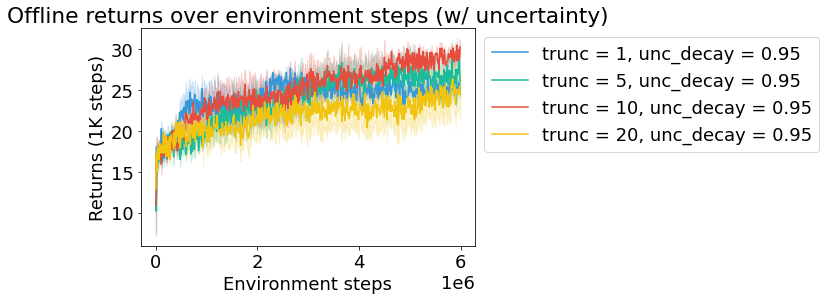

In [79]:
# with trunc

plot_info_trunc_unfiltered = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': f'trunc = 1, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_1"][0].uncertainty_decay}'},
    f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': f'trunc = 5, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_5"][0].uncertainty_decay}'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': f'trunc = 10, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_10"][0].uncertainty_decay}'},
#     f'uf{level}m_cnn_lstm_trunc_15': {'color': alizarin, 'label': f'trunc = 10, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_10"][0].uncertainty_decay}'}
    f'uf{level}m_cnn_lstm_trunc_20': {'color': sunflower, 'label': f'trunc = 20, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_20"][0].uncertainty_decay}'}

}


fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc_unfiltered.items():
    data = all_mapped_data_trunc_unfiltered[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Returns (1K steps)")
ax.set_title(f'Offline returns over environment steps (w/ uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

k: 1, step_means: [22.44626667 24.88583333 22.91356667 25.11383333 24.8914    ]
k: 5, step_means: [18.31803333 26.52813333 23.3031     24.36843333 26.384     ]
k: 10, step_means: [27.30666667 26.94873333 20.35773333 23.40593333 27.0667    ]
k: 20, step_means: [20.45543333 27.4392     25.0735     18.15283333 18.03536667]


/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_44752/2887478013.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_44752/2887478013.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_44752/2887478013.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_44752/28

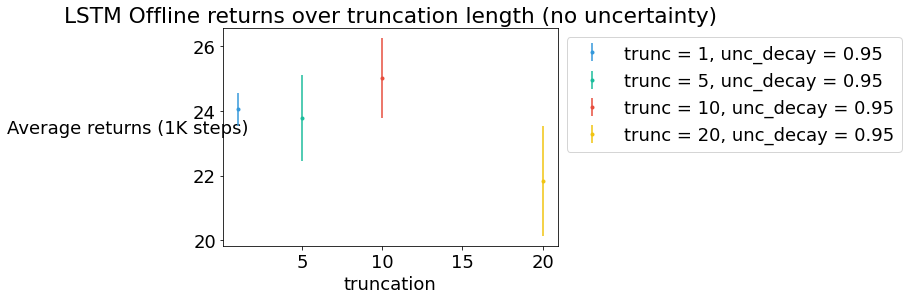

In [80]:
fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc_unfiltered.items():
    data = all_mapped_data_trunc_unfiltered[k]
    key = info['label']
    color = info['color']
    x = np.array([int(k.split('_')[-1])])

    step_means = data.mean(axis=-1)
    mean = step_means.mean(axis=0)
    std_err = step_means.std(axis=0) / np.sqrt(step_means.shape[0])
    print(f"k: {x.item()}, step_means: {step_means}")

    ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
# ax.set_xlim(0, 11)
# ax.set_ylim(12, 18)

ax.set_xlabel('truncation')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'LSTM Offline returns over truncation length (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')